<a href="https://colab.research.google.com/github/renad30/KAUST-ACADEMY-stage2/blob/main/day4_Pytorch_Linear_NN_MNIST_AutoEncoder_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install torch torchvision torchsummary
%pip install numpy
%pip install matplotlib

clear_output()

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Contents

Today we'll attempt to create a number image generator through auto encoders. Here's the technique

1. The model has 2 parts, an encoder and a decoder
2. The encoder takes number image (mnist) and converts it into an embedding/encoding of specified size (output of encoder last layer). by passing it through multiple linear layers.
3. The decoder then takes that encoding and attempts to re-create the original image
4. During training, our cost function is the difference between generated image and original image. we'll use MSE Loss for this
5. Once the training is complete, we'll create our own embeddings of specified size ourselves and run it through the decoder to generate images


Note: In this notebook we'll limit ourselves to Linear Layers or BatchNorm's only (and activations). Which means NO CNN, attention, or anything fancier. For this reason, the performance might be questionable. What we wanna see is the model trying to capture the pattern?

You need to know:

1. **pytorch** (for impelementation)
2. a bit of **torch dataloaders and datasets** (not necessary but helps understanding how we're loading data)
3. A little bit of **matplotlib** (for result and training trajectory visualization)

In [2]:
batch_size = 64

train_transforms = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

train_data = MNIST(root='./datasets', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.28MB/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [3]:
class AutoEncoderGenerator(nn.Module): #-> to parts : 1- encoder 2- decoder

  def __init__(self, dim_z):
    super().__init__()
    self.Encoder = nn.Sequential(

        nn.Linear(28*28, 1024), # my note: input - output
        nn.LeakyReLU(),
        nn.BatchNorm1d(1024), # we can delete it but its better to have it "1d" means leanier

        nn.Linear(1024, 512),
        nn.LeakyReLU(),
        nn.BatchNorm1d(512),

        nn.Linear(512, 256),
        nn.LeakyReLU(),

        nn.Linear(256, dim_z), # make the image smaller
        nn.Tanh(),
      )


    self.Decoder = nn.Sequential(
        nn.Linear(dim_z, 256),
        nn.LeakyReLU(),

        nn.Linear(256, 512),
        nn.LeakyReLU(),

        nn.Linear(512, 1024),
        nn.LeakyReLU(),

        nn.Linear(1024, 28*28),
        nn.Sigmoid()
      )

  def forward(self, x):

    original_shape = x.shape
    x = torch.flatten(x, start_dim=1) # my note : same as veiw (-1,28*28) , we want the feature dim

    z = self.Encoder(x) # my note -> we make the image smaller
    x = self.Decoder(z) # my note : reverse

    x = x.view(original_shape)

    return x


In [5]:
dim_z = 128 # my note : z is the bottle neck
model = AutoEncoderGenerator(dim_z=dim_z)

In [6]:
summary(model, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
         LeakyReLU-2                 [-1, 1024]               0
       BatchNorm1d-3                 [-1, 1024]           2,048
            Linear-4                  [-1, 512]         524,800
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                  [-1, 256]         131,328
         LeakyReLU-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             Tanh-10                  [-1, 128]               0
           Linear-11                  [-1, 256]          33,024
        LeakyReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 512]         131,584
        LeakyReLU-14                  [

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

num_epochs = 20
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [8]:
train_losses = []

for i in range(num_epochs):

  epoch_weighted_loss = 0
  for (X, _) in train_loader:

    X = X.to(device)

    Xhat = model(X)  # Xhat because we're trying to have the model regenerate what's fed to it (X)

# my note : update the weghits:

    optimizer.zero_grad()
    loss = criterion(Xhat, X)
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += loss.item()*len(X)

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  print(f'epoch {i}/{num_epochs}, loss = {epoch_loss}')

  train_losses.append(epoch_loss)

epoch 0/20, loss = 0.060467418976624804
epoch 1/20, loss = 0.035706160408258435
epoch 2/20, loss = 0.02935382755100727
epoch 3/20, loss = 0.02583678672214349
epoch 4/20, loss = 0.023500711781779926
epoch 5/20, loss = 0.021675092042485872
epoch 6/20, loss = 0.020196248387296993
epoch 7/20, loss = 0.019004593520363173
epoch 8/20, loss = 0.018121822678049404
epoch 9/20, loss = 0.017333975143233937
epoch 10/20, loss = 0.016657954970002175
epoch 11/20, loss = 0.016046220744649568
epoch 12/20, loss = 0.015462875603636106
epoch 13/20, loss = 0.014889311882356803
epoch 14/20, loss = 0.014389793645838896
epoch 15/20, loss = 0.013971937743326028
epoch 16/20, loss = 0.013563322097063065
epoch 17/20, loss = 0.013191803116103013
epoch 18/20, loss = 0.0128174078459541
epoch 19/20, loss = 0.012502308404445649


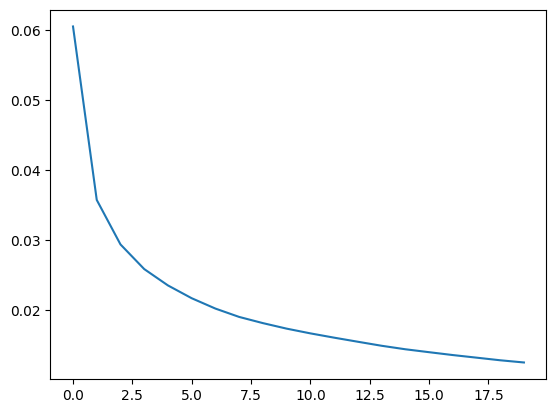

In [10]:
plt.plot(train_losses)

In [11]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im, cmap="gray")
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

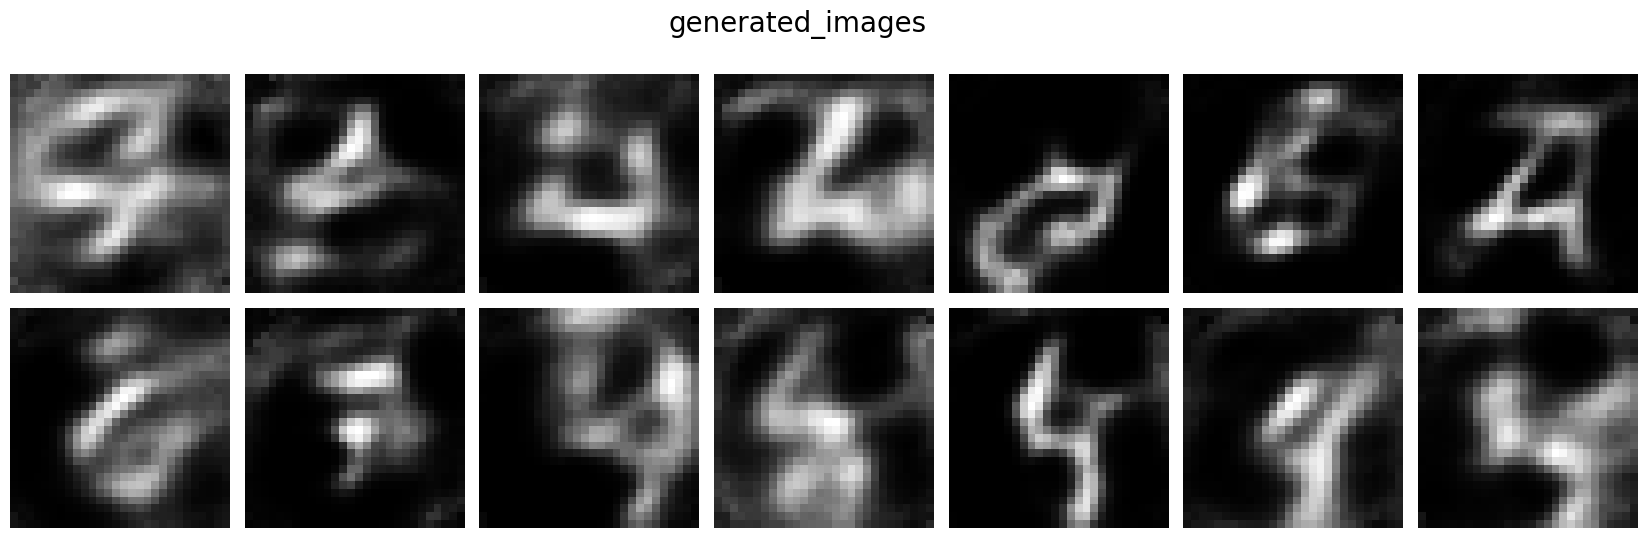

In [12]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder

rows, cols = 2, 7 # my note : 2*7 = 14 dim and z is the number of totsl numbers "128"
sample_encodings = (torch.rand(rows*cols, dim_z).to(device) - 0.5) * 2 # encoding space: [-1,1)
with torch.no_grad():
  generations = model.Decoder(sample_encodings).cpu() # convert to cpu so we can print it
  generations = generations.reshape(-1, 28, 28, 1)   # torch (batch_size, channels, height, width) but we are using mapblot so we should change the channels
display_image_grid(generations, rows, cols, "generated_images")

The images aren't too fancy but we can see it's trying to learn.
In a few images we can also guess the number it's trying to generate